# 앙상블

일련의 예측기를 **앙상블**이라고 한다. 또한, 앙상블을 이용한 학습을 **앙상블 학습**이라고 하고, 앙상블 학습 알고리즘을 **앙상블 방법**이라고 한다.

가장 인기 있는 앙상블 방법으로는 **배깅**, **부스팅**, **스태킹** 등이 있다.

대표적인 앙상블은 **랜덤 포레스트**이다.

# 투표 기반 분류기

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기(범주형 예측기)의 예측을 모아 **가장 많이 선택된 클래스로 예측**하는 것이다.  
이렇게 다수결 투표로 정해지는 (앙상블) 분류기를 **직접 투표(hard voting) 분류기**라고 한다.

다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많다.

또한, 각 분류기가 약한 학습기(weak learner, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) 강한 학습기가 될 수 있다.

아래 코드를 보면 알 수 있듯이, (랜덤 추측보다 조금 더 나은) 51%의 정확도를 내는 분류기가 많을수록 앞면이 다수가 될 확률(앙상블이 정확히 예측할 확률)이 증가한다. (1000개 -> 74.7%, 10000개 -> 97.8%)

이는 큰 수의 법칙 때문이다. 즉, 시행을 많이 할수록 실제 확률이 통계적 확률에 가까워지기 때문이다.

In [1]:
from scipy.stats import binom # 이항 분포
print(f"{1-binom.cdf(499, 1000, 0.51): .3f}") # 1000번 던져서 앞면이 절반 이상 나올 확률
print(f"{1-binom.cdf(4999, 10000, 0.51): .3f}") # 10000번 던져서 앞면이 절반 이상 나올 확률

 0.747
 0.978


하지만 이는 모든 분류기가 완벽하게 독립적이고, 오차에 상관관계가 없어야 가능하다. 여기서는 같은 데이터로 훈련시키므로 이런 가정에 맞지 않고, 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 **앙상블의 정확도가 낮아진다.**

따라서, 앙상블 방법은 **예측기가 가능한 한 서로 독립적**일 때 **최고의 성능을 발휘**한다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다. 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 높인다.

---

직접 투표

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.15, random_state=42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train = X[train_index]; X_test = X[test_index]
    y_train = y[train_index]; y_test = y[test_index]

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
RandomForestClassifier 0.99
SVC 0.99
VotingClassifier 0.99


간접 투표

확률이 높은 투표에 비중을 더 두기 때문에 **직접 투표 방식보다 성능이 높다**.  
이 방식을 사용하기 위해서는 voting="soft"로 하고, **모든 분류기가 클래스의 확률을 추정**(SVC인 경우  probability=True로 설정)할 수 있으면 된다.

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True) # probability=True로 설정하면 클래스의 확률을 추정한다.

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

In [5]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
RandomForestClassifier 0.99
SVC 0.99
VotingClassifier 0.99


# 배깅과 페이스팅

위의 코드처럼 앙상블에 사용할 다양한 분류기를 만들기 위해서 각기 다른 훈련 알고리즘을 사용할 수도 있다.  
또 다른 방법은 같은 훈련 알고리즘을 사용하고 훈련 세트의 **서브셋을 무작위로 구성해서 분류기를 각기 다르게 학습**시키는 것이다.

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **배깅**(bagging = bootstrap(중복을 허용한 리샘플링) aggregating(응집)), 중복을 허용하지 않고 샘플링하는 방식을 **페이스팅**(pasting)이라고 한다.

참고로, 앙상블의 수집 함수는 전형적으로 분류일 때는 통계적 최빈값, 회귀일 때는 평균을 계산한다.

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 **훨씬 크게 편향**되어 있지만, 개별 예측기들로 앙상블 예측기를 만들어 **수집 함수를 통과하면 편향과 분산이 모두 감소**한다.

배깅와 페이스팅을 사용하면 학습과 예측을 모두 **병렬로 수행**할 수 있다.

## 사이킷런의 배깅과 페이스팅

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1 # `n_jobs=-1` = 모든 코어 사용
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.99


In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.98


In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

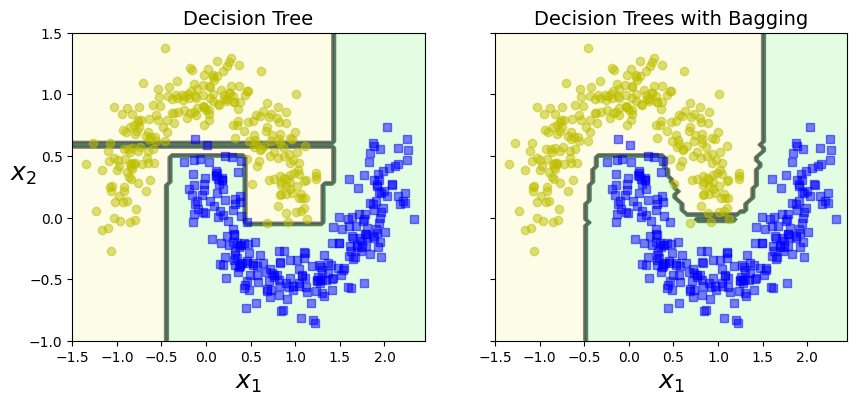

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

부트스트래핑이 서브셋의 다양성을 증가시키므로 배깅이 페이스팅보다 편향은 조금 더 높다. 서브셋의 다양성을 증가시키는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다.  
따라서, 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 배깅을 더 선호한다.

## oob 평가

배깅을 사용할 때 선택되지 않은 훈련 샘플을 **oob(out-of-bag) 샘플**이라고 한다.

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 **검증 세트를 사용하지 않고 oob 샘플을 사용**해 평가할 수 있다.

아래 코드에서 앙상블의 oob에 대한 평가는 **각 예측기의 oob 평가를 평균**하여 얻는다.

In [11]:
bag_clf =BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.985

In [12]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.99

In [13]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.54545455, 0.45454545],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.44767442, 0.55232558],
       [0.        , 1.        ],
       [0.01104972, 0.98895028],
       [0.99484536, 0.00515464],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99489796, 0.00510204],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.98963731, 0.01036269],
       [1.        , 0.        ],
       [1.

# 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 **특성 샘플링**도 지원한다. max_feature(선택 가능한 최대 특성의 수), bootstrap_features(복원 추출 여부) 매개변수로 조절

훈련 샘플과 특성을 모두 샘플링하는 것을 **랜덤 패치 방식**(random patches method)라고 한다.  
훈련 샘플을 모두 사용하고(bootstrap=False AND max_samples=1로 설정) 특성은 샘플링하는(bootstrap=True OR/AND max_features 1.0보다 작게 설정) 것을 **랜덤 서브스페이스 방식**(random subspaces method)이라고 한다.

# 랜덤 포레스트

**랜덤 포레스트**는 배깅 방법(혹은 페이스팅 방법)을 적용한 결정 트리의 앙상블이다.

**BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신**
결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier(회귀 문제의 경우 RandomForestRegressor)를 사용할 수 있다.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

RandomForestClassifier는 DecisionTreeClassifier와 BaggingClassifier의 **매개변수를 모두** 가지고 있다.  
  
하지만 몇 가지 예외가 있다.  
DecisionTreeClassifier의 매개변수는 splitter="best", presort=False로 **고정**이고, BaggingClassifier의 매개변수는 max_samples=1.0, base_estimator=(지정된 매개변수를 사용한 DecisionTreeClassifier)로 **고정**이다.

랜덤 포레스트 알고리즘은 결정 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식(그리디 알고리즘)으로 **무작위성을 더 주입**한다.  
  
이는 트리를 더욱 다양하게 만들고 (배깅, 페이스팅으로 편향을 손해보고 분산을 낮춘 것처럼 다시 한 번) **편향을 손해보는 대신 분산을 낮추어** 전체적으로 더 훌륭한 모델을 만든다. 

다음 코드는 BaggingClassifier를 사용해 앞의 **RandomForestClassifier와 거의 유사**하게 만든 것이다.

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1 # bootstrap = True이면 배깅, False이면 페이스팅
)

## 엑스트라 트리

트리를 더욱 무작위하게 만들기 위해 (보통의 결정 트리처럼) 최적의 임계값을 찾는 대신 **후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택**한다.

이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리**(extremely random trees) 앙상블(줄여서 **엑스트라 트리**(extra-trees))이라고 부른다.

이 역시도 **편향은 늘어나지만 분산을 낮추게 된다**.

모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소용되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 **엑스트라 트리가 훨씬 빠르다**.

사용법은 RandomForestClassifier(RandomForestRegressor)와 동일하다.

## 특성 중요도

### 불순도 감소량

**불순도 감소량** 수식  
$\Delta i(t) = i(t) - (\frac{N_{left}}{N_t} \times i(left) + \frac{N_{right}}{N_t} \times i(right))$  

여기서
- $i(t)$는 노드 $t$의 불순도(Gini 불순도 혹은 엔트로피)
- $i(left)$는 왼쪽 자식 노드의 불순도
- $i(right)$는 오른쪽 자식 노드의 불순도
- $N_{left}, N_{right}$는 각각 왼쪽 및 오른쪽 자식 노드에 도달한 샘플 수

$\frac{N_{left}}{N_t} \times i(left) + \frac{N_{right}}{N_t} \times i(right)$는 왼쪽 노드와 오른쪽 노드로 분할하여 구해진 왼쪽 불순량과 오른쪽 불순량에 대한 **가중 평균**이다.

$\Delta i(t)$(불순도 감소량)이 음수가 될 수도 있는데 **항상 양수일 수 밖에 없는 이유**는 결정 트리가 노드를 분할할 때 $\Delta i(t)$이 0보다 커야만 분할하기 때문이다.

### 특성 $j$의 중요도 $FI(j)$

**특성 j의 중요도** $FI(j)$는 그 특성이 포함된 모든 노드에서의 불순도 감소량을 **가중 평균**한 것이다. 여기서 가중치는 노드의 샘플 수이다.

$FI(j) = \underset{t\ \in\ nodes\ where\ j\ is\ used}{\Sigma} \frac{N_t}{N} \times \Delta i(t)$

여기서
- $FI(j)$는 특성 $j$의 중요도
- $t$는 트리의 특정 노드
- $N_t$는 노드 $t$에 도달한 샘플 수
- $N$는 트리의 루트 노드에 도달한 전체 샘플 수
- $\Delta i(t)$는 특성 $j$를 사용한 노드 $t$에서의 불순도 감소량

### 최종 정규화

각 특성 중요도 $FI(j)$는 모든 특성 중요도의 합이 1이 되도록 정규화한다.

$FI(j) = \frac {FI(j)} {\underset{k\ \in\ features}{\Sigma} FI(k)}$

여기서, $k, j$는 특성이다.

### 회귀 모델에서의 특성 중요도 계산

분류 모델에서는 **불순도**를 이용하여 특성에 대한 중요도를 계산한다.

회귀 모델에서는 평균 제곱 오차(mse)와 같은 **예측 오차**를 이용하여 특성에 대한 중요도를 계산한다.

### 랜덤 포레스트로 특성 중요도 확인

랜덤 포레스트로 iris 학습

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10508642901087134
sepal width (cm) 0.021507220003811754
petal length (cm) 0.446877851361734
petal width (cm) 0.42652849962358286


랜덤 포레스트로 mnist 학습

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [18]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [19]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

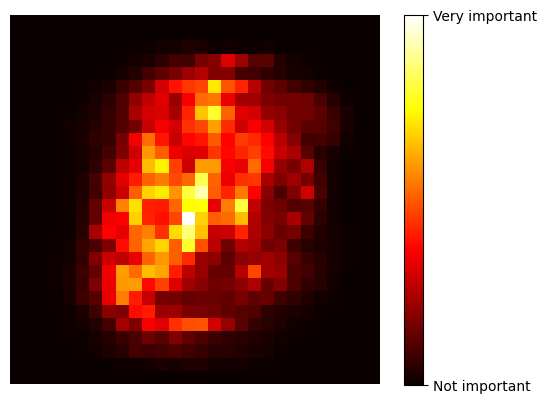

In [20]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

위 두 코드와 같이 랜덤 포레스트는 특성을 선택해야 할 때 **어떤 특성이 중요한지 빠르게 확인**할 수 있어 매우 편리하다.

# 부스팅

**부스팅**(boosting, 원래는 가설 부스팅(hypothesis boosting))은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말한다.  
부스팅은 **앞의 모델을 보완**해나가면서 일련의 예측기를 학습시킨다. **에이다부스트**(AdaBoost, adaptive boosting)와 **그레이디언트 부스팅**(gradient boosting)이 가장 인기가 있다.

## 에이다부스트

In [21]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/handson2/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

## 그레이디언트 부스팅

그레이디언트 부스팅은 결정 트리를 이용한 부스팅 알고리즘이다.

결정 트리를 이용하여 최초 타깃값에 대해 학습한 이후 잔여 오차에 대해 여러 번 학습할 수 있다. 회귀에 대한 결정 트리는 **mse가 최소화** 되도록 분할되므로 **각 노드의 예측값이 해당 노드의 타깃값(잔여 오차)들과 대체적으로 가까워진다**(잔여 오차에 대한 예측값을 타깃값에 대한 예측값에 모두 더할 것이므로 결과적으로 **전체 오차가 줄어든다**).
  
이전 학습기에서 발생한 잔여 오차에 대해 학습한 **결정 트리가 많아질수록 전체 오차가 대체적으로 줄어든다**. 하지만, 항상 전체 오차가 줄어드는 것은 아니므로 오차가 가장 줄어드는 결정 트리의 개수가 존재한다.

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [23]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [24]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [25]:
X_new = X[0].reshape(-1, 2)

In [26]:
tree_reg1.predict(X_new)

array([0.95959596])

In [27]:
tree_reg2.predict(X_new)

array([-0.02774977])

In [28]:
tree_reg3.predict(X_new)

array([-0.00767409])

In [29]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.9241721])

트리를 먼저 훈련시키고 최적의 트리 수를 찾는 방법

learning_rate가 낮으면 많은 n_estimator가 필요하지만 일반적으로 예측의 성능은 좋아진다.

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, learning_rate=1.0)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(34))

위 코드처럼 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾는 대신 **실제로 훈련을 중지하는 방법으로 조기 종료를 구현**할 수 있다. warm_start = True로 설정하면 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다.

warm_start는 이전 학습 결과로 모델을 초기화할지에 대한 여부를 결정한다.

In [32]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120 +1):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 조기 종료
n_estimators

120

확률적 그레이디언트 부스팅(stochastic gradient boosting)은 무작위로 선택된 25%의 훈련 샘플로 학습되기 때문에 편향이 높아지는 대신 분산이 낮아진다. 또한 훈련 속도를 상당히 높인다.

In [33]:
gbrt = GradientBoostingRegressor(max_depth=2, subsample=0.25)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_val)
errors = mean_squared_error(y_val, y_pred)
errors

np.float64(0.022897603468772496)

최적화된 그레이디언트 부스팅 구현으로 XGBoost가 유명하다. 매우 빠른 속도, 확장성, 이식성이 이 패키지의 목표이다.

In [34]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

early_stopping_rounds라는 속성으로 자동 조기 종료를 설정할 수 있는데 왜 인지는 모르겠는데 실행이 안 된다.

In [36]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

# 스태킹

(홀드 아웃을 이용한 )블렌딩이든, (k겹-폴드를 이용한 )스태킹이든 각 예측기를 훈련 세트로 훈련시킨 후 **검증 세트의 예측값**을 구한다. **블렌딩**은 훈련 세트의 일부인 검증 세트의 예측값을 구하고, **스태킹**은 폴드마다 해당 폴드의 검증 세트의 예측값을 모두 모아서 훈련 세트 크기와 동일한 검증 세트의 예측값을 구한다.

마찬가지로, 블렌딩이든 스태킹이든 각 예측기를 훈련 세트로 훈련시킨 후 **테스트 세트의 예측값**을 구한다. **블렌딩**은 테스트 세트의 예측값을 한 번 구하기만 하면 되지만, **스태킹**은 폴드마다 테스트 세트의 예측값을 구하므로 테스트 세트의 예측값을 평균한다(폴드 축으로 테스트 세트의 예측값을 모두 모아 폴드 크기만큼 나눠준다).

이렇게 생성된 검증 세트의 예측값과 테스트 세트의 예측값은 각각 최종 모델인 블렌더의 훈련 세트와 테스트 세트가 된다. **블렌더**는 검증 세트의 예측값(블렌더의 훈련 세트)으로 훈련한 후 테스트 세트의 예측값(블렌더 테스트 세트)로 모델의 성능을 평가한다.

한 발짝 더 나아가면, 블렌더의 훈련 세트를 교차 검증하여 블렌더의 일반화 성능을 더 끌어올릴 수 있다.